In [1]:
import sys 
sys.path.append('../..')
from cox.utils import Parameters
from cox.store import Store
from cox.readers import CollectionReader
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import itertools
import numpy as np
import torch as ch
from torch import Tensor
import torch.nn as nn
from torch.distributions import Gumbel, Uniform
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import datetime
from delphi.oracle import oracle

# set default tensor type 
ch.set_default_tensor_type(ch.cuda.FloatTensor)

## Default Experiment Parameters

In [18]:
# procedure hyperparameters
args = Parameters({ 
    'epochs': 25,
    'num_workers': 0, 
    'batch_size': 100,
    'bias': True,
    'num_samples': 10000,
    'clamp': True, 
    'radius': 5.0, 
    'var_lr': 1e-2,
    'lr': 1e-1,
    'shuffle': False, 
    'tol': 1e-2,
    'samples': 10000,  # number of samples to generate for ground truth
    'in_features': 3, # number of in-features to multi-log-reg
    'k': 3, # number of classes
    'lower': -1, # lower bound for generating ground truth weights
    'upper': 1,  # upper bound for generating ground truth weights
    'trials': 10,
})

# CE Latent Variable Model Loss

In [3]:
gumbel = Gumbel(0, 1)

class GumbelCE(ch.autograd.Function):
    @staticmethod
    def forward(ctx, pred, targ):
        ctx.save_for_backward(pred, targ)
        loss = ch.nn.CrossEntropyLoss()
        return loss(pred, targ)

    @staticmethod
    def backward(ctx, grad_output):
        pred, targ = ctx.saved_tensors
        # make num_samples copies of pred logits
        stacked = pred[None, ...].repeat(1000, 1, 1)        
        # add gumbel noise to logits
        rand_noise = gumbel.sample(stacked.size())
        noised = stacked + rand_noise 
        noised_labs = noised.argmax(-1)
        # remove the logits from the trials, where the kth logit is not the largest value
        good_mask = noised_labs.eq(targ)[..., None]
        inner_exp = 1 - ch.exp(-rand_noise)
        avg = (inner_exp * good_mask).sum(0) / (good_mask.sum(0) + 1e-5) / pred.size(0)
        return -avg , None
    
class TruncatedGumbelCE(ch.autograd.Function):
    @staticmethod
    def forward(ctx, pred, targ, phi):
        ctx.save_for_backward(pred, targ)
        ctx.phi = phi
        ce_loss = ch.nn.CrossEntropyLoss()
        return ce_loss(pred, targ)

    @staticmethod
    def backward(ctx, grad_output):
        pred, targ = ctx.saved_tensors
        # make num_samples copies of pred logits
        stacked = pred[None, ...].repeat(args.num_samples, 1, 1)   
        # add gumbel noise to logits
        rand_noise = gumbel.sample(stacked.size())
        noised = stacked + rand_noise 
        # truncate - if one of the noisy logits does not fall within the truncation set, remove it
        filtered = ch.all(ctx.phi(noised).bool(), dim=2).float().unsqueeze(2)
        noised_labs = noised.argmax(-1)
        # mask takes care of invalid logits and truncation set
        mask = noised_labs.eq(targ)[..., None] * filtered
        inner_exp = 1 - ch.exp(-rand_noise)
                
        avg = ((inner_exp * mask).sum(0) / (mask.sum(0) + 1e-5) - (inner_exp * filtered).sum(0) / (filtered.sum(0) + 1e-5)) 
        return -avg / pred.size(0), None, None

# Truncated Multinomial Logistic Regression Experiments

Membership oracles for Multinomial Logistic Regression Logits 

In [4]:
class DNN_Lower(oracle): 
    """
    Lower bound truncation on the DNN logits.
    """
    def __init__(self, lower): 
        self.lower = lower
        
    def __call__(self, x): 
        return (x > self.lower).float()

In [5]:
class Identity(oracle): 
    def __call__(self, x): 
        return ch.ones(x.size())

Truncate Dataset

In [26]:
phi = DNN_Lower(Tensor([-1, -1, -1]))
# phi = Identity()

In [27]:
# generate ground-truth from uniform distribution
U = Uniform(args.lower, args.upper)
ground_truth = nn.Linear(in_features=args.IN_FEATURES, out_features=args.K, bias=args.bias)
ground_truth.weight = nn.Parameter(U.sample(ch.Size([args.K, args.IN_FEATURES])))
if ground_truth.bias is not None: 
    ground_truth.bias = nn.Parameter(U.sample(ch.Size([args.K,])))
print("ground truth weights: {}".format(ground_truth.weight))
print("ground truth bias: {}".format(ground_truth.bias))
# independent variable 
U_ = Uniform(-5, 5)
X = U_.sample(ch.Size([args.samples, args.IN_FEATURES]))
# determine base model logits 
z = ground_truth(X)
# apply softmax to unnormalized likelihoods
y = ch.argmax(ch.nn.Softmax(dim=1)(z), dim=1)

# TRUNCATE
trunc = phi(z)
indices = ch.all(trunc.bool(), dim=1).float().nonzero(as_tuple=False).flatten()
y_trunc = y[indices]
x_trunc = X[indices]
alpha = x_trunc.size(0) / X.size(0)
print("alpha: {}".format(alpha))

# all synthetic data 
ds = TensorDataset(x_trunc, y_trunc)
# split ds into training and validation data sets
train_length = int(len(ds)*.8)
val_length = len(ds) - train_length
train_ds, val_ds = ch.utils.data.random_split(ds, [train_length, val_length])
# train and validation loaders
train_loader = DataLoader(train_ds, num_workers=args.num_workers, batch_size=args.batch_size)
val_loader = DataLoader(val_ds, num_workers=args.num_workers, batch_size=args.batch_size)

# test dataset
y_test = y[~indices]
x_test = X[~indices]

ground truth weights: Parameter containing:
tensor([[-0.7573,  0.9134,  0.2062],
        [-0.2224, -0.9683, -0.4470],
        [ 0.3331, -0.1171, -0.1744]], requires_grad=True)
ground truth bias: Parameter containing:
tensor([-0.3866, -0.6208,  0.1278], requires_grad=True)
alpha: 0.1321


In [28]:
# TRUNC CE LOSS TABLE FOR METRICS
LATENT_CE_TABLE_NAME = 'trunc_multi_log_reg'

STORE_PATH = '/home/pstefanou/MultinomialLogisticRegression'
store = Store(STORE_PATH)

store.add_table(LATENT_CE_TABLE_NAME, { 
    'trunc_train_acc': float, 
    'trunc_val_acc': float, 
    'trunc_train_loss': float, 
    'trunc_val_loss': float,
    'naive_train_acc': float, 
    'naive_val_acc': float, 
    'naive_train_loss': float, 
    'naive_val_loss': float,
    'trunc_test_acc': float, 
    'naive_test_acc': float,
    'epoch': int,
})

Logging in: /home/pstefanou/MultinomialLogisticRegression/191b082b-e059-44e2-8560-98b661ae9dd5


In [29]:
trunc_multi_log_reg = nn.Linear(in_features=args.IN_FEATURES, out_features=args.K, bias=args.bias)
naive_multi_log_reg = nn.Linear(in_features=args.IN_FEATURES, out_features=args.K, bias=args.bias)
# optimizer and scheduler
trunc_opt = ch.optim.SGD(trunc_multi_log_reg.parameters(), lr=1e-1)
naive_opt = ch.optim.SGD(naive_multi_log_reg.parameters(), lr=1e-1)
trunc_scheduler = ch.optim.lr_scheduler.CosineAnnealingLR(trunc_opt, args.epochs)
naive_scheduler = ch.optim.lr_scheduler.CosineAnnealingLR(naive_opt, args.epochs)
trunc_ce_loss = TruncatedGumbelCE.apply
ce_loss = ch.nn.CrossEntropyLoss()

In [30]:
for i in range(args.trials):
    for epoch in range(args.epochs): 
        # train loop
        trunc_train_loss, trunc_train_acc = Tensor([]), Tensor([])
        naive_train_loss, naive_train_acc = Tensor([]), Tensor([])
        for batch_X, batch_y in train_loader: 
            # truncated multinomial regression
            trunc_opt.zero_grad()
            pred = trunc_multi_log_reg(batch_X)
            loss = trunc_ce_loss(pred, batch_y, phi)
            loss.backward() 
            trunc_opt.step()
            trunc_scheduler.step()
            # keep track of truncated algorithm training loss and accuracy
            acc = (ch.argmax(ch.nn.Softmax(dim=1)(pred), dim=1) == batch_y).sum() / batch_y.size(0)
            trunc_train_loss = ch.cat([trunc_train_loss, Tensor([loss])]) if trunc_train_loss.size() != ch.Size([0]) else Tensor([loss])
            trunc_train_acc = ch.cat([trunc_train_acc, Tensor([acc])]) if trunc_train_acc.size() != ch.Size([0]) else Tensor([acc])
            
            # naive multinomial regression
            naive_opt.zero_grad()
            pred = naive_multi_log_reg(batch_X)
            loss = ce_loss(pred, batch_y)
            loss.backward() 
            naive_opt.step()
            naive_scheduler.step()
            # keep track of naive algorithm training loss and accuracy
            acc = (ch.argmax(ch.nn.Softmax(dim=1)(pred), dim=1) == batch_y).sum() / batch_y.size(0)
            naive_train_loss = ch.cat([naive_train_loss, Tensor([loss])]) if naive_train_loss.size() != ch.Size([0]) else Tensor([loss])
            naive_train_acc = ch.cat([naive_train_acc, Tensor([acc])]) if naive_train_acc.size() != ch.Size([0]) else Tensor([acc])
        # validation loop
        trunc_val_loss, trunc_val_acc = Tensor([]), Tensor([])
        naive_val_loss, naive_val_acc = Tensor([]), Tensor([])
        with ch.no_grad(): 
            for batch_X, batch_y in val_loader: 
                # truncated validation loop
                pred = trunc_multi_log_reg(batch_X)
                loss = trunc_ce_loss(pred, batch_y, phi)
                # keep track of algorithm validation loss and accuracy
                acc = (ch.argmax(ch.nn.Softmax(dim=1)(pred), dim=1) == batch_y).sum() / batch_y.size(0)            
                trunc_val_loss = ch.cat([trunc_val_loss, Tensor([loss])]) if trunc_val_loss.size() != ch.Size([0]) else Tensor([loss])
                trunc_val_acc = ch.cat([trunc_val_acc, Tensor([acc])]) if trunc_val_acc.size() != ch.Size([0]) else Tensor([acc])
                
                # naive validation loop
                pred = naive_multi_log_reg(batch_X)
                loss = ce_loss(pred, batch_y)
                # keep track of algorithm validation loss and accuracy
                acc = (ch.argmax(ch.nn.Softmax(dim=1)(pred), dim=1) == batch_y).sum() / batch_y.size(0)            
                naive_val_loss = ch.cat([naive_val_loss, Tensor([loss])]) if naive_val_loss.size() != ch.Size([0]) else Tensor([loss])
                naive_val_acc = ch.cat([naive_val_acc, Tensor([acc])]) if naive_val_acc.size() != ch.Size([0]) else Tensor([acc])

            # test set accuracy
            trunc_test_pred = trunc_multi_log_reg(x_test)
            naive_test_pred = naive_multi_log_reg(x_test)

            trunc_test_acc = (ch.argmax(ch.nn.Softmax(dim=1)(trunc_test_pred), dim=1) == y_test).sum() / y.size(0)
            naive_test_acc = (ch.argmax(ch.nn.Softmax(dim=1)(naive_test_pred), dim=1) == y_test).sum() / y.size(0)
                
        store[LATENT_CE_TABLE_NAME].append_row({ 
            'trunc_train_acc': float(trunc_train_acc.mean()), 
            'trunc_val_acc': float(trunc_val_acc.mean()), 
            'trunc_train_loss': float(trunc_train_loss.mean()), 
            'trunc_val_loss': float(trunc_val_loss.mean()),
            'naive_train_acc': float(naive_train_acc.mean()), 
            'naive_val_acc': float(naive_val_acc.mean()), 
            'naive_train_loss': float(naive_train_loss.mean()), 
            'naive_val_loss': float(naive_val_loss.mean()),
            'trunc_test_acc': float(trunc_test_acc), 
            'naive_test_acc': float(naive_test_acc),
            'epoch': int(epoch + 1),
        })
    
store.close()

# Read Experiment Data from Store

In [31]:
reader = CollectionReader(STORE_PATH)
results = reader.df(LATENT_CE_TABLE_NAME)
reader.close() # close reader
results.head()

100%|██████████| 1/1 [00:00<00:00, 204.91it/s]


,trunc_train_acc,trunc_val_acc,trunc_train_loss,trunc_val_loss,naive_train_acc,naive_val_acc,naive_train_loss,naive_val_loss,trunc_test_acc,naive_test_acc,epoch,exp_id
0,0.474545,0.645385,1.406397,0.869947,0.776104,0.867180,0.657807,0.558466,0.0896,0.1051,1,191b082b-e059-44e2-8560-98b661ae9dd5
1,0.604286,0.662051,0.842338,0.732262,0.900455,0.867180,0.480427,0.515588,0.0960,0.1065,2,191b082b-e059-44e2-8560-98b661ae9dd5
2,0.657727,0.698718,0.773865,0.705131,0.898636,0.862051,0.467345,0.509120,0.0979,0.1070,3,191b082b-e059-44e2-8560-98b661ae9dd5
3,0.734156,0.784615,0.662086,0.543951,0.895000,0.838462,0.448821,0.461286,0.1048,0.1078,4,191b082b-e059-44e2-8560-98b661ae9dd5
4,0.823182,0.823077,0.494652,0.453027,0.888636,0.856923,0.406061,0.409397,0.1103,0.1112,5,191b082b-e059-44e2-8560-98b661ae9dd5


# Loss and Accuracy Curves

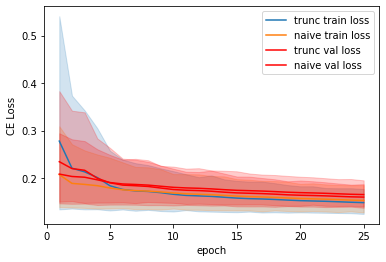

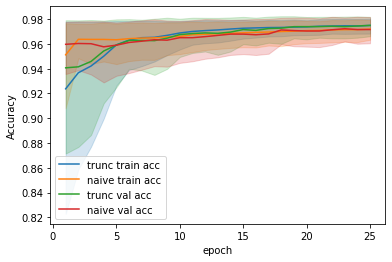

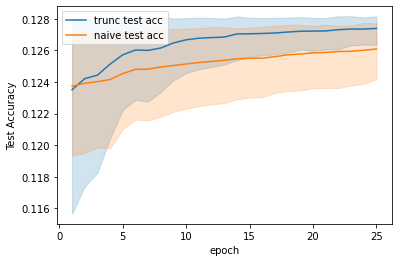

In [32]:
sns.lineplot(data=results, x='epoch', y='trunc_train_loss', label='trunc train loss')
sns.lineplot(data=results, x='epoch', y='naive_train_loss', label='naive train loss')
sns.lineplot(data=results, x='epoch', y='trunc_val_loss', color='red', label='trunc val loss')
ax = sns.lineplot(data=results, x='epoch', y='naive_val_loss', color='red', label='naive val loss')
ax.set(xlabel='epoch', ylabel='CE Loss')
plt.show()

sns.lineplot(data=results, x='epoch', y='trunc_train_acc', label='trunc train acc')
sns.lineplot(data=results, x='epoch', y='naive_train_acc', label='naive train acc')
sns.lineplot(data=results, x='epoch', y='trunc_val_acc', label='trunc val acc')
ax = sns.lineplot(data=results, x='epoch', y='naive_val_acc', label='naive val acc')
ax.set(xlabel='epoch', ylabel='Accuracy')
plt.show()

sns.lineplot(data=results, x='epoch', y='trunc_test_acc', label='trunc test acc')
ax = sns.lineplot(data=results, x='epoch', y='naive_test_acc', label='naive test acc')
ax.set(xlabel='epoch', ylabel='Test Accuracy')
plt.show()

In [39]:
trunc_multi_log_reg.weight

Parameter containing:
tensor([[-2.6573,  3.4919,  1.0961],
        [-0.8624, -3.2136, -1.1666],
        [ 1.6849,  0.0851, -0.1340]], requires_grad=True)

In [36]:
naive_multi_log_reg.weight

Parameter containing:
tensor([[-1.9136,  3.4561,  1.1448],
        [-0.1245, -3.2757, -1.1225],
        [ 2.1877,  0.1857, -0.0396]], requires_grad=True)

In [37]:
naive_multi_log_reg.bias

Parameter containing:
tensor([-0.3503, -1.2745,  1.3401], requires_grad=True)

In [38]:
trunc_multi_log_reg.bias

Parameter containing:
tensor([ 0.2135, -0.6709,  1.9963], requires_grad=True)

In [40]:
ground_truth.weight

Parameter containing:
tensor([[-0.7573,  0.9134,  0.2062],
        [-0.2224, -0.9683, -0.4470],
        [ 0.3331, -0.1171, -0.1744]], requires_grad=True)

In [41]:
ground_truth.bias

Parameter containing:
tensor([-0.3866, -0.6208,  0.1278], requires_grad=True)